In [1]:
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn import linear_model

import japanize_matplotlib

%matplotlib inline

# 乱数seedの固定
np.random.seed(seed=123)

/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/japanize_matplotlib/__init__.py:13: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [21]:
# E-step
def EStep(k_size, y, lambda_vec, coef_vec, sigma2_vec, X):
    '''
    y[i]
    lambda[k]
    mu[k]
    sigma[k]
    '''
    I = len(y)
    # 中身を初期化せずに配列を作成する関数である。
    # 2行, 1000列の配列を生成
    responsibility = sp.empty((k_size, I))
    
    for k in sp.arange(k_size):
        norm = stats.norm(loc=np.mean(X@coef_vec[k]), scale=sp.sqrt(sigma2_vec[k]))
        responsibility[k] = lambda_vec[k] *norm.pdf(y)

    responsibility = responsibility / sp.sum(responsibility, axis=0)
    return responsibility

def MStep(k_size, responsibility, y, X):

    lambda_vec = sp.empty(k_size)
    #mu_vec = sp.empty(k_size)
    coef_vec = []
    sigma2_vec = sp.empty(k_size)
    

    for k in sp.arange(k_size):
        r_k = responsibility[k]
        
        #coef_vec[k] = np.linalg.inv(X.T @ np.diag(r_k) @ X) @ X.T @np.diag(r_k)@y
        coef_vec.append(np.linalg.inv(X.T @ np.diag(r_k) @ X) @ X.T @np.diag(r_k)@y)
        
        #lambda_vec[k] = sp.sum(r_k) / sp.sum(responsibility)
        lambda_vec[k] = sp.sum(r_k) / responsibility.shape[1]
        
        #mu_vec[k] = sp.sum(r_k * y) / sp.sum(r_k)
        
        sigma2_vec[k] = sp.sum(r_k * (y - np.mean(X@coef_vec[k]))**2) / sp.sum(r_k)
        
    mu_vec = [np.mean(X@coef_vec[0]), np.mean(X@coef_vec[1])]
        
        
        

    return lambda_vec, mu_vec, coef_vec, sigma2_vec

In [22]:
def calc_mix_pdf(k_size, x, lambda_vec, coef_vec, sigma2_vec, X):
    pdf = sp.zeros_like(x)

    for k in sp.arange(k_size):
        norm_k = stats.norm(loc=np.mean(X@coef_vec[k]), scale=sp.sqrt(sigma2_vec[k]))
        
        # pdf (Probability density function) 確率密度関数
        # xのときの値を取得
        pdf += lambda_vec[k] * norm_k.pdf(x)
    return pdf

In [25]:
def mix_em( FEATS):
    df = pd.read_excel("../../data/data_covid_fix_name.xlsx")
    df = df.dropna().reset_index(drop=True)
    
    sscaler = preprocessing.StandardScaler() # インスタンスの作成

    sscaler.fit(df[FEATS])    
    X = sscaler.transform(df[FEATS]) # xを変換
    
    
    # データを早期、晩期に分割
    y=df["date_first"].values
    y_early = df["date_first"][df["date_first"]<40]
    y_late = df["date_first"][df["date_first"]>40]

    x_early = X[df["date_first"]<40]
    x_late = X[df["date_first"]>40]
    
    clf_early = linear_model.LinearRegression()
    clf_early.fit(x_early, y_early)

    # 回帰係数
    print("早期感染国の回帰係数：", clf_early.coef_)

    # 切片 (誤差)
    print("早期感染国の切片：", clf_early.intercept_)

    # 決定係数
    print("早期感染国の決定係数：", clf_early.score(x_early, y_early))
    
    clf_late = linear_model.LinearRegression()
    clf_late.fit(x_late, y_late)

    # 回帰係数
    print("晩期感染国の回帰係数：", clf_late.coef_)

    # 切片 (誤差)
    print("晩期期感染国の切片：", clf_late.intercept_)

    # 決定係数
    print("晩期感染国の決定係数：", clf_late.score(x_late, y_late))
    
    # 早期感染国のβ
    coef1_first=[clf_early.intercept_] + list(clf_early.coef_)

    # 晩期感染国のβ
    coef2_first=[clf_late.intercept_] + list(clf_late.coef_)


    first_df = pd.DataFrame(coef1_first, columns=["早期感染国β(初期値)"], index=["Intercept"]+ FEATS)
    first_df["晩期感染国β(初期値)"] = coef2_first
    
    X = np.insert(X, 0, 1, axis=1)

    # muの初期値の計算
    # mu = βx
    mu1_first = np.mean(X@coef1_first)
    mu2_first = np.mean(X@coef2_first)


    # sigmaの初期値
    sigma1_first = np.sum((y_early - np.mean(y_early))**2)/len(y_early)
    sigma2_first = np.sum((y_late - np.mean(y_late))**2)/len(y_late)
    
    # 混合正規分布の数
    k_size = 2

    # 混合比率
    lambda_vec=[0.15, 0.85]

    # 説明変数のパラメータ
    mu_vec = [mu1_first, mu2_first]

    # 分散(sigma)の初期値
    sigma2_vec=[sigma1_first, sigma2_first]

    # coefの初期値
    coef_vec = [coef1_first, coef2_first]
    
    print("f1の混合比率：", lambda_vec[0])
    print("mu1：", mu_vec[0])
    print("sigma1：", sigma2_vec[0])
    print("f2の混合比率：", lambda_vec[1])
    print("mu2：", mu_vec[1])
    print("sigma2：", sigma2_vec[1])
    
    # データ(-6から6までを200こ)
    x = sp.linspace(np.min(y), np.max(y), 150)
    plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, coef_vec, sigma2_vec, X), label="ini")
    plt.show()
    
    # 100回繰り返す
    for i in sp.arange(100+1):
        # Estep
        # responsibilityの更新 
        # responsibility = EStep(k_size, y, lambda_vec, mu_vec, sigma2_vec)
        responsibility = EStep(k_size, y, lambda_vec, coef_vec, sigma2_vec, X)

        # Mstep
        # 混合割合, 平均, 分散の更新
        lambda_vec, mu_vec, coef_vec, sigma2_vec = MStep(k_size, responsibility, y, X)
        mu_vec = [np.mean(X@coef_vec[0]), np.mean(X@coef_vec[1])]

        if i % 10 == 0:
            print("i:", i, "lambda", lambda_vec.round(4), "mu", np.round(mu_vec, 4), "sigma2", sigma2_vec.round(4))
            plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, coef_vec, sigma2_vec, X), label=f"i:{i}", linestyle="--")

    plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, coef_vec, sigma2_vec, X), label=f"last{i}", linestyle="-")

    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # 推定結果の可視化
    plt.hist(y, density=True)
    plt.plot(x, calc_mix_pdf(k_size, x, lambda_vec, coef_vec, sigma2_vec, X), label="ini")
    
    print("f1の混合比率：", lambda_vec[0])
    print("mu1：", mu_vec[0])
    print("sigma1", sigma2_vec[0])

    print("f2の混合比率：", lambda_vec[1])
    print("mu2：", mu_vec[1])
    print("sigma2：", sigma2_vec[1])
    
    res_df = pd.DataFrame(coef_vec[0].round(4), index=["Intercept"]+FEATS,  columns=["早期感染国"])
    res_df["晩期感染国"] = coef_vec[1].round(4)
    res_df
    
    return res_df, first_df

早期感染国の回帰係数： [-1.31426229  4.16512633]
早期感染国の切片： 31.397766235728554
早期感染国の決定係数： 0.16148826050078113
晩期感染国の回帰係数： [-3.20788383  2.22260009]
晩期期感染国の切片： 69.61834545752009
晩期感染国の決定係数： 0.1388016659829332
f1の混合比率： 0.15
mu1： 31.397766235728547
sigma1： 27.16824196597353
f2の混合比率： 0.85
mu2： 69.61834545752009
sigma2： 100.76979353958708


/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:88: DeprecationWarning: scipy.linspace is deprecated and will be removed in SciPy 2.0.0, use numpy.linspace instead
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.zeros_like is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros_like instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  after removing the cwd from sys.path.
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  """


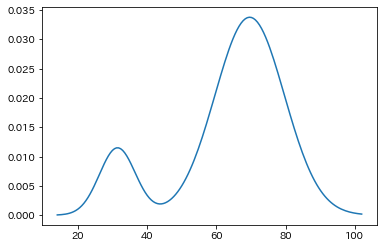

i: 0 lambda [0.1534 0.8466] mu [31.7688 69.6138] sigma2 [ 47.5488 101.5338]


/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: scipy.empty is deprecated and will be removed in SciPy 2.0.0, use numpy.empty instead
  if sys.path[0] == '':
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  from ipykernel import kernelapp as app
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: scipy.sum is deprecated and w

i: 10 lambda [0.3102 0.6898] mu [56.7783 69.5714] sigma2 [641.3804  80.7599]


/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: scipy.empty is deprecated and will be removed in SciPy 2.0.0, use numpy.empty instead
  if sys.path[0] == '':
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  from ipykernel import kernelapp as app
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: scipy.empty is deprecated and will 

i: 20 lambda [0.3816 0.6184] mu [58.7155 69.3254] sigma2 [614.8902  70.9395]
i: 30 

/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: scipy.empty is deprecated and will be removed in SciPy 2.0.0, use numpy.empty instead
  if sys.path[0] == '':
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  from ipykernel import kernelapp as app
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: scipy.empty is deprecated and will 

lambda [0.3861 0.6139] mu [58.7942 69.3225] sigma2 [611.5122  70.5352]
i: 40 lambda [0.3864 0.6136] mu [58.7995 69.3223] sigma2 [611.2786  70.5079]


/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: scipy.empty is deprecated and will be removed in SciPy 2.0.0, use numpy.empty instead
  if sys.path[0] == '':
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  from ipykernel import kernelapp as app
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: scipy.empty is deprecated and will 

i: 50 lambda [0.3864 0.6136] mu [58.7999 69.3223] sigma2 [611.2625  70.5061]
i: 60 lambda [0.3864 0.6136] mu [58.7999 69.3223] sigma2 [611.2613  70.5059]
i: 70 lambda [0.3864 0.6136] mu [58.7999 69.3223] sigma2 [611.2613  70.5059]


/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.zeros_like is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros_like instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  after removing the cwd from sys.path.
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  """
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: scipy.empty is deprecated and will be removed in SciPy 2.0.0, use numpy.empty instead
  if sys.path[0] == '':
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: scipy.arange is dep

i: 80 lambda [0.3864 0.6136] mu [58.7999 69.3223] sigma2 [611.2613  70.5059]
i: 90 lambda [0.3864 0.6136] mu [58.7999 69.3223] sigma2 [611.2613  70.5059]
i: 100 lambda [0.3864 0.6136] mu [58.7999 69.3223] sigma2 [611.2613  70.5059]


/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.zeros_like is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros_like instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  after removing the cwd from sys.path.
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  """
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: scipy.empty is deprecated and will be removed in SciPy 2.0.0, use numpy.empty instead
  if sys.path[0] == '':
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: scipy.arange is dep

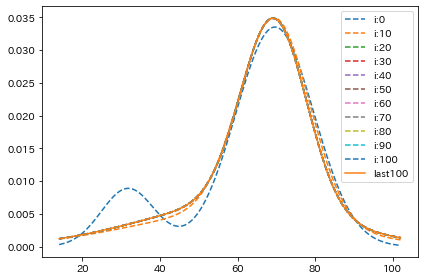

/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.zeros_like is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros_like instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  after removing the cwd from sys.path.
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  """


f1の混合比率： 0.3864491242162183
mu1： 58.79990829549309
sigma1 611.2612622126887
f2の混合比率： 0.6135508757837818
mu2： 69.32230514837312
sigma2： 70.50591048954811


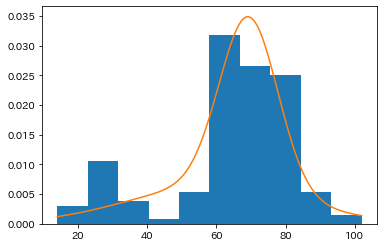

In [36]:
FEATS = [ "hf","dist"]
df_res, df_first = mix_em(FEATS)

In [37]:
df_res

,早期感染国,晩期感染国
Intercept,58.7999,69.3223
hf,-10.6432,-2.8998
dist,13.3377,1.8332


In [38]:
df_first

,早期感染国β(初期値),晩期感染国β(初期値)
Intercept,31.397766,69.618345
hf,-1.314262,-3.207884
dist,4.165126,2.222600


早期感染国の回帰係数： [ 1.08102583 -0.30279662 -1.25510802  0.56827608 -0.61012585 -2.74742777
  7.16612826]
早期感染国の切片： 36.12437142088592
早期感染国の決定係数： 0.5806309997799328
晩期感染国の回帰係数： [-0.99528236 -4.6712097   4.35925526 -8.82541691 -1.82251389 -2.57763224
  1.59193151]
晩期期感染国の切片： 68.7654941965318
晩期感染国の決定係数： 0.5146712962999649
f1の混合比率： 0.15
mu1： 36.12437142088593
sigma1： 27.16824196597353
f2の混合比率： 0.85
mu2： 68.7654941965318
sigma2： 100.76979353958708


/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:88: DeprecationWarning: scipy.linspace is deprecated and will be removed in SciPy 2.0.0, use numpy.linspace instead
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.zeros_like is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros_like instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  after removing the cwd from sys.path.
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  """


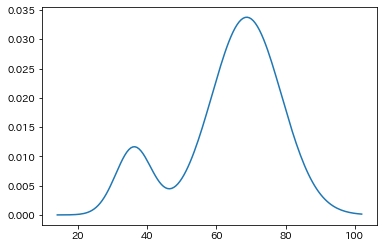

i: 0 lambda [0.1548 0.8452] mu [38.1992 68.7557] sigma2 [145.098  103.5231]


/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:93: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: scipy.empty is deprecated and will be removed in SciPy 2.0.0, use numpy.empty instead
  if sys.path[0] == '':
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  from ipykernel import kernelapp as app
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: scipy.sum is deprecated and w

i: 10 lambda [0.382 0.618] mu [60.543  68.4227] sigma2 [649.1274  70.6335]
i: 20 lambda [0.3999 0.6001] mu [60.7274 68.4094] sigma2 [631.8345  69.1105]
i: 30 lambda [0.4013 0.5987] mu [60.741  68.4084] sigma2 [630.5433  69.0003]
i: 40 lambda [0.4014 0.5986] mu [60.742  68.4084] sigma2 [630.442   68.9916]
i: 50 lambda [0.4014 0.5986] mu [60.7421 68.4084] sigma2 [630.434  68.991]


/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: scipy.empty is deprecated and will be removed in SciPy 2.0.0, use numpy.empty instead
  if sys.path[0] == '':
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  from ipykernel import kernelapp as app
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: scipy.empty is deprecated and will 

/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: DeprecationWarning: scipy.empty is deprecated and will be removed in SciPy 2.0.0, use numpy.empty instead
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: scipy.empty is deprecated and will be removed in SciPy 2.0.0, use numpy.empty instead
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: DeprecationWarning: scipy.sum is deprecated and will be removed in SciPy 2.0.0, use numpy.sum instead
/Users/masanoritakahashi/anacon

i: 60 lambda [0.4014 0.5986] mu [60.7421 68.4084] sigma2 [630.4334  68.9909]
i: 70 lambda [0.4014 0.5986] mu [60.7421 68.4084] sigma2 [630.4334  68.9909]
i: 80 lambda [0.4014 0.5986] mu [60.7421 68.4084] sigma2 [630.4334  68.9909]
i: 90 lambda [0.4014 0.5986] mu [60.7421 68.4084] sigma2 [630.4334  68.9909]
i: 100 lambda [0.4014 0.5986] mu [60.7421 68.4084] sigma2 [630.4334  68.9909]


/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.zeros_like is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros_like instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  after removing the cwd from sys.path.
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  """
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.zeros_like is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros_like instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.arange is deprecated and w

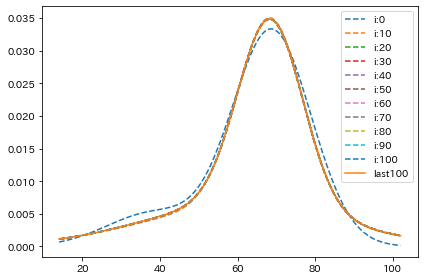

f1の混合比率： 0.4014115457245645
mu1： 60.742109612609276
sigma1 630.4333586395021
f2の混合比率： 0.5985884542754354
mu2： 68.40835778116643
sigma2： 68.99089325445107


/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: scipy.zeros_like is deprecated and will be removed in SciPy 2.0.0, use numpy.zeros_like instead
  
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: scipy.arange is deprecated and will be removed in SciPy 2.0.0, use numpy.arange instead
  after removing the cwd from sys.path.
/Users/masanoritakahashi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: scipy.sqrt is deprecated and will be removed in SciPy 2.0.0, use numpy.lib.scimath.sqrt instead
  """


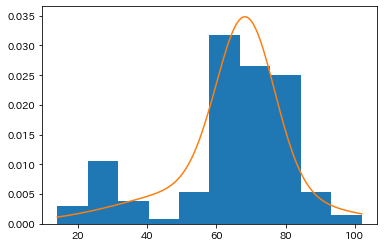

In [57]:
FEATS = ["hf", "pop",  "urb", "gdp","dist", "air", "detection"]

FEATS = [ "hf", "urb", "air", "pop", "gdp", "detection"]
df_res, df_first = mix_em(FEATS)

In [55]:
df_res

,早期感染国,晩期感染国
Intercept,27.6720,68.8998
hf,3.7881,-0.6450
urb,-0.2511,-4.0103
air,-0.6565,4.9016
pop,0.3898,-9.3063
gdp,-0.1208,-2.8115
detection,-2.4609,-2.9686


In [56]:
df_first

,早期感染国β(初期値),晩期感染国β(初期値)
Intercept,27.706694,68.924369
hf,3.847780,-0.651066
urb,-0.212951,-3.997060
air,-0.655912,5.035802
pop,0.389038,-9.473606
gdp,-0.160500,-2.824348
detection,-2.507140,-2.943951
